In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:09<00:00, 124MB/s]
100% 1.06G/1.06G [00:09<00:00, 117MB/s]


In [5]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/dogs-vs-cats.zip' mode='r'>>

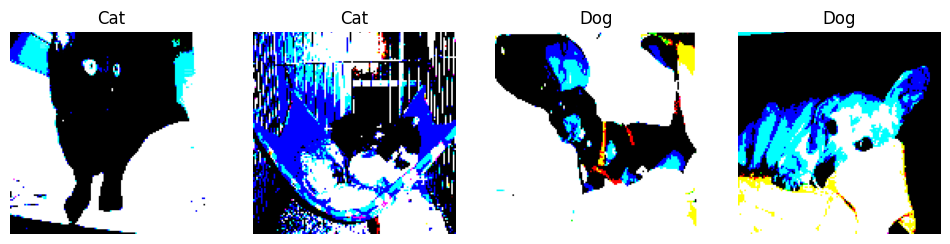

63/63 ━━━━━━━━━━━━━━━━━━━━ 369s 6s/step
Model Accuracy: 59.00%


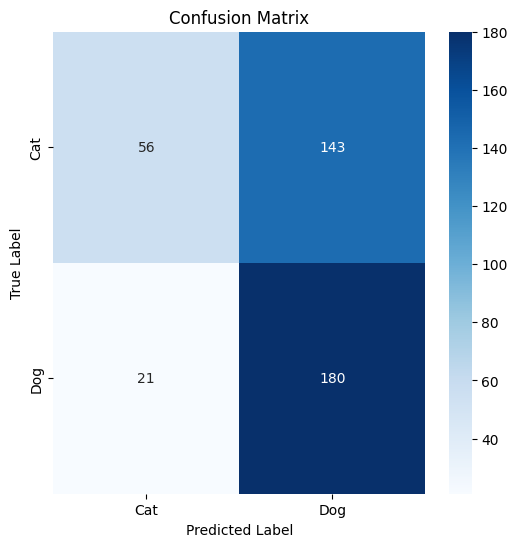

In [6]:
# Import necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = 128  # Larger image size for VGG16 input
DATASET_DIR = "/content/dogs_vs_cats/train"
CATEGORIES = ["cats", "dogs"]

# Function to load images, with option to limit the number of images per category
def load_images(data_dir, img_size, limit=1000):
    images = []
    labels = []

    for category in CATEGORIES:
        folder_path = os.path.join(data_dir, category)
        label = 0 if category == "cats" else 1
        count = 0

        for img_file in os.listdir(folder_path):
            if count >= limit:
                break
            img_path = os.path.join(folder_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)
                count += 1
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load and preprocess images
X, y = load_images(DATASET_DIR, IMG_SIZE)
X = preprocess_input(X)  # Preprocess for VGG16 input

# Display sample images of cats and dogs
def show_sample_images(X, y, img_size):
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))
    cat_count, dog_count = 0, 0
    i = 0
    while cat_count < 2 or dog_count < 2:
        if y[i] == 0 and cat_count < 2:
            img = X[i]
            axes[cat_count].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[cat_count].set_title("Cat")
            axes[cat_count].axis('off')
            cat_count += 1
        elif y[i] == 1 and dog_count < 2:
            img = X[i]
            axes[dog_count + 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[dog_count + 2].set_title("Dog")
            axes[dog_count + 2].axis('off')
            dog_count += 1
        i += 1

    plt.show()

# Show sample images
show_sample_images(X, y, IMG_SIZE)

# Extract features using a pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
features = vgg_model.predict(X)
X_features = features.reshape(features.shape[0], -1)  # Flatten features

# Split data into training and test sets, then standardize
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train an SVM model with RBF kernel and optimized hyperparameters
svm_model = SVC(kernel='rbf', C=100, gamma=0.001)
svm_model.fit(X_train, y_train)

# Predict and evaluate model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

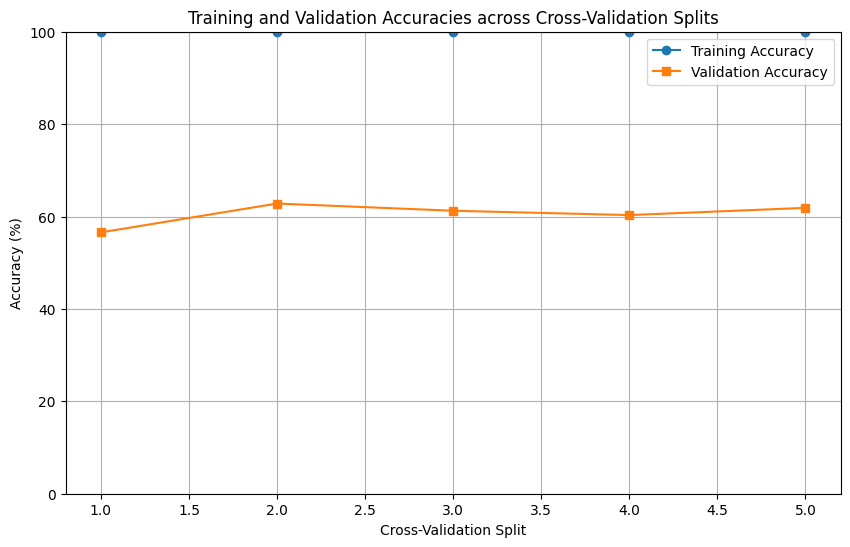

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set up cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

train_accuracies = []
val_accuracies = []

# Perform cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    # Train the model
    svm_model.fit(X_tr, y_tr)

    # Evaluate on the training set
    y_train_pred = svm_model.predict(X_tr)
    train_acc = accuracy_score(y_tr, y_train_pred)
    train_accuracies.append(train_acc * 100)

    # Evaluate on the validation set
    y_val_pred = svm_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_acc * 100)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, n_splits + 1), val_accuracies, marker='s', label='Validation Accuracy')
plt.title("Training and Validation Accuracies across Cross-Validation Splits")
plt.xlabel("Cross-Validation Split")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid()
plt.show()